# "Anticipez les besoins en consommation électrique de bâtiments"
_Modelling Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [200]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [201]:
if is_colab==True:
    
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Noticing user about files that has to be in the current working directory.

In [202]:
def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

Installations and importations required for Google Colab version.

In [203]:
# !pip freeze > requirements_modelling.txt

In [204]:
import os

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements_modelling.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements_modelling.txt')
    !pip install -r requirements_modelling.txt

In [205]:
from P4_functions import *

Importation of modules and packages. 

In [206]:
import io
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')

# from ipywidgets import interact, interact_manual

import dill

# from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.inspection import permutation_importance

import category_encoders as ce

import scipy.stats as st

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

Setting pandas display options

In [207]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

To play audio text-to-speech during execution.

In [208]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [209]:
speak('Packages and modules successfully imported')

### 0.1 Importing the dataset

In [210]:
if is_colab==True:
    path_csv = 'DATA/Cleaned_data.csv' 
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv = '../DATA/Cleaned_data.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [211]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [212]:
speak('Dataset successfully imported')

### 0.2 Overview

#### Brief description

In [213]:
df.shape

(1651, 65)

In [214]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier', 'ZipCode', 'La

Printing total nb and percentage of null

In [215]:
print_null_pct(df)

nb of null:  2191 
pct of null:  2.0


Showing columns where there are still NaN values

In [216]:
df.isna().sum(axis=0)[df.isna().sum(axis=0)!=0]

TaxParcelIdentificationNumber       1
ENERGYSTARScore                   542
Comments                         1648
dtype: int64

#### Checking the outliers

In [217]:
sel = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge','MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
       'ExtsurfVolRatio', 'ENERGYSTARScore']

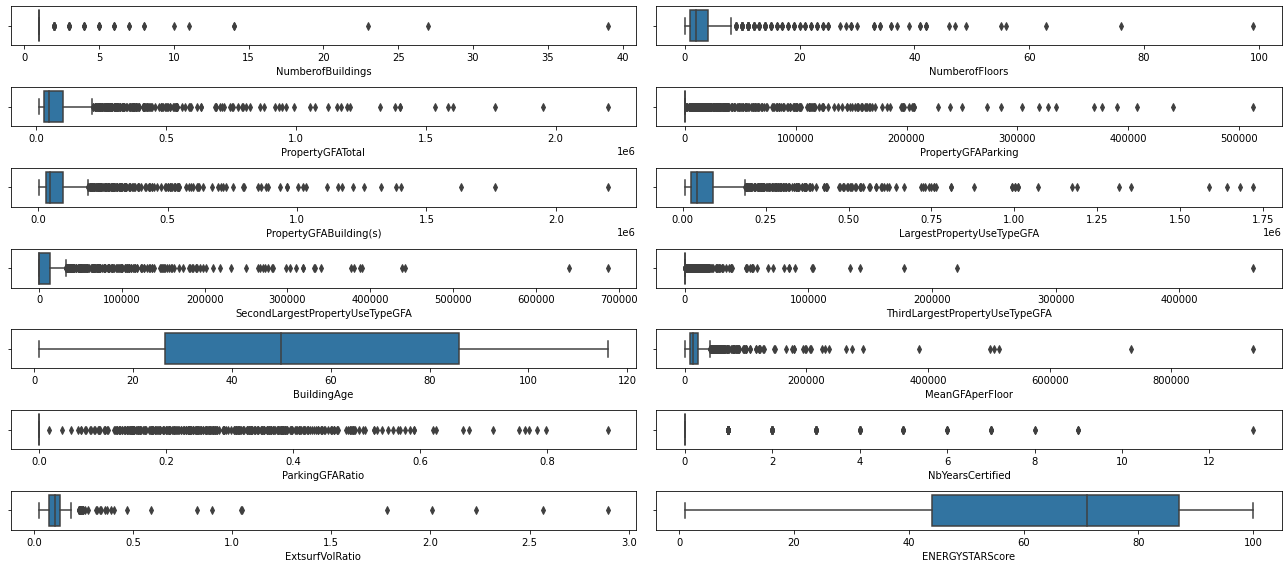

In [218]:
fig = plt.figure()
for i, c in enumerate(df[sel].columns,1):
    ax = fig.add_subplot(df[sel].shape[1]//2, 2, i)
    sns.boxplot(df[c], ax=ax)
fig.set_size_inches(18,8)
fig.tight_layout()

In [219]:
speak('Description overview done')

## 1 Data preprocessing

### 1.1 Target data transformation

We already found in the Cleaning_EDA notebook that the distribution of the target data could become almost normal with logarithmic transformation.

We'll test our models with and without this log transformation (see the 'set_dict_scv_params' function in P4_Modelling.py).

### 1.2 Feature transformation

We want to evaluate the impact of the transformation strategies for quantitative and categorical data. We'll split the columns in 4 types.

__Quantitative data__

Integers or float.

__Categorical data__

Categorical data are all nominal data, none of them are ordinal.
- Boolean : 'CertifiedPreviousYear'
- low cardinality (less than 12 categories):
'BuildingType', 'MainEnergy', 'EnergyProfile', 'Outlier'
- high cardinality (12 or more categories) :
('Neighborhood', 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType', 'PrimaryPropertyType')

The transformation of the columns is all (encoding of categorical and normalisation of quantitative) included in the Class CustTransformer (see P4_funtions.py file). The transformation options are passed to the GridSearchCV or RandomizedSearchCV through the param_grid dictionnary.

### 1.3 Outliers filtering

We detected outliers during the analysis process. We'll put in place automatic outliers filtering in the pipeline we'll use for model optimization.

Filtering out outliers on 'PropertyGFATotal' and 'SiteEnergyUseWN(kBtu)'

In [220]:
# print("before", df.shape)
# df = df[df['PropertyGFATotal'].between(df['PropertyGFATotal'].mean()-3*df['PropertyGFATotal'].std(),
#                                      df['PropertyGFATotal'].mean()+3*df['PropertyGFATotal'].std())]
# print("after", df.shape)

In [221]:
# print("before", df.shape)
# df = df[df['SiteEnergyUseWN(kBtu)'].between(df['SiteEnergyUseWN(kBtu)'].mean()-3*df['SiteEnergyUseWN(kBtu)'].std(),
#                                      df['SiteEnergyUseWN(kBtu)'].mean()+4*df['SiteEnergyUseWN(kBtu)'].std())]
# print("after", df.shape)

### 1.4 Features selection

Let's evaluate the quality and the colinearity of the features independent of the choice of the model to see if all features are worth keeping in the modelling process.

In [222]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
                # 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

#### Feature selection based on colinearity (Pearson correlation)

In [223]:
### SEUILLAGE DES COEFFICIENT DE CORRELATION

#### Feature selection based on colinearity (Variance Inflation Factor) 

In [224]:
#### ENCODAGE ORDINAL DES VALEURS CATEGORIELLES D'ABORD

# select_from_vif_(XXXXXXX, thresh=XXXXXXX)

#### Feature selection based on the variance of the data

In [225]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

#### ENCODAGE ORDINAL DES VALEURS CATEGORIELLES D'ABORD

# X_tr_Q = X_tr.select_dtypes(include=(np.number))
# for c in X_tr_Q.columns :
#     print(f"{c:-<40}{np.var(X_tr_Q.loc[:,c])}")

This analysis leads to the following conclusions:

__Quantitative data__

We noticed highly correlated quantitative features in the P4_Cleaning_Analysis notebook.
- 'PropertyGFATotal' is strongly correlated with 'PropertyGFABuilding(s)'
- 'PropertyGFABuilding(s)' is strongly correlated with 'LargestPropertyUseTypeGFA'
- 'ExtsurfVolRatio' is strongly correlated with 'NumberofBuildings'

__Categorical data__

- 'LargestPropertyUseType'(57) is strongly correlated with 'PrimaryPropertyType'(29)

At first, we'll keep all the data, except latitude and longitude, and identification data.
We'll put in place an automatic feature selection process in the pipeline we'll use for optimization.

In [226]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[target_cols] # 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'
df_Xy = pd.concat([df_X, df_y], axis=1)

### 1.5 Outlier detection and labelling

We'll suppose a contamination of 5% of our data.

The X and y features will be both considered inthe outlier detection process.

We'll label outliers using:
- Zscore on the quantitative columns
- LocalOutlierFactor
- IsolationForest

Let's see at first how the different thresholds impact on the data

#### Zscore

total nb of observations:  (1651, 15)


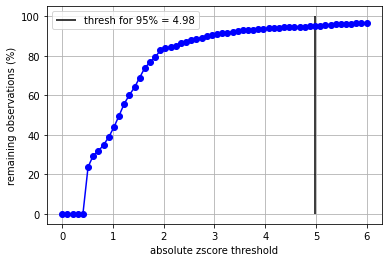

In [227]:
# ZSCORE PARTIE QUANTITATIVE

df_num = df_Xy.select_dtypes(include=[np.number]).copy('deep')
print("total nb of observations: ", df_num.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
tab_shape=[]
thresholds = np.linspace(0,6,60)
for t in thresholds:
    zsf = ZscoreSampleFilter(thresh=t)
    df_ = zsf.fit_transform(df_num)
    tab_shape.append(df_.shape[0]*100/df_num.shape[0])
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = thresholds)
thresh = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(thresh, 0, 100, label='thresh for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, thresh))
plt.xlabel("absolute zscore threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### LocalOutlierFactor

In [228]:
# Encoding categorical features
ct = CustTransformer(strat_binary='ord',
                     strat_low_card='ord',
                     strat_high_card='ord',
                     strat_quant='none')
df_enc = ct.fit_transform_df(df_Xy)

total nb of observations:  (1651, 27)


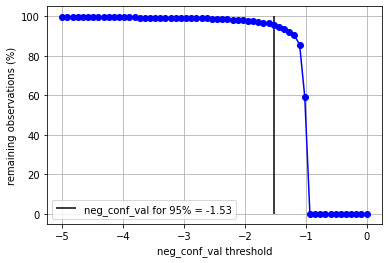

In [229]:
print("total nb of observations: ", df_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
neg_conf_vals = np.linspace(-5,0,60)
tab_shape=[]
for ncv in neg_conf_vals:
    loff = LOFSampleFilter(neg_conf_val=ncv, n_neighbors=20)
    df_ = loff.fit_transform(df_enc)
    prop = df_.shape[0]*100/df_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = neg_conf_vals)
neg_conf_val = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(neg_conf_val, 0, 100, label='neg_conf_val for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, neg_conf_val))
plt.xlabel("neg_conf_val threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### IsolationForest

total nb of observations:  (1651, 27)


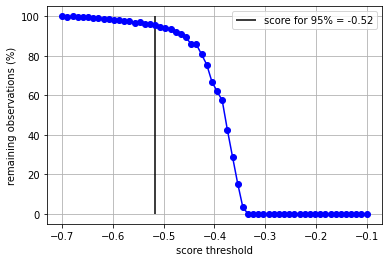

In [230]:
# ISOLATION FOREST (après encodage des valeurs catégorielles)

print("total nb of observations: ", df_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
score_samples_list = np.linspace(-0.1,-0.7,60)
tab_shape=[]
for sc in score_samples_list:
    isolf = IsolForestSampleFilter(score_samples=sc, n_estimators=100)
    df_ = isolf.fit_transform(df_enc)
    prop = df_.shape[0]*100/df_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = score_samples_list)
score = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(score, 0, 100, label='score for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, score))
plt.xlabel("score threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### Comparison of the outliers algorithms

Let's now put the detection results by the three algorithms for the same contamination fraction in a dataframe.

In [231]:
'''detects the zscore threshold to put in the ZscoreSampleFilter in order
to use the proportion of contamination
May accept a dataframe with all dtype columns but selects
only numerical columns to compute the threshold'''

def Zscore_thresh_compute(df, contamination=0.05):
    df_num = df.select_dtypes(include=[np.number])
    tab_shape=[]
    thresholds = np.linspace(0,6,60)
    for t in thresholds:
        zsf = ZscoreSampleFilter(thresh=t)
        df_ = zsf.fit_transform(df_num)
        tab_shape.append(df_.shape[0]/df_num.shape[0])
    res = pd.DataFrame(tab_shape, index = thresholds)
    thresh = res.loc[res.values>1-contamination].idxmin()[0]
    return thresh

In [232]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

df_outliers = pd.DataFrame(index=df_Xy.index)

# zscore outlier detection column
df_outliers['ZscoreOutlier'] = np.nan
thresh = Zscore_thresh_compute(df_num, contamination=0.05) 
zsf = ZscoreSampleFilter(thresh=thresh)
df_ = zsf.fit_transform(df_num)
df_outliers.loc[df_.index, 'ZscoreOutlier'] = False
df_outliers['ZscoreOutlier'] = df_outliers['ZscoreOutlier']\
                              .where(df_outliers['ZscoreOutlier']==False, True)

# local outlier factor outlier dectection column
df_outliers['LOFOutlier'] = np.nan
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
res = lof.fit_predict(df_enc)
df_outliers['LOFOutlier'] = pd.Series(res,
                                      index = df_outliers.index).map({-1: True,
                                                                      1: False})

# isolation forest outlier detection column
df_outliers['IsolFOutlier'] = np.nan
isolf = IsolationForest(n_estimators=100, contamination=0.05)
res = isolf.fit_predict(df_enc)
df_outliers['IsolFOutlier'] = pd.Series(res,
                                      index = df_outliers.index).map({-1: True,
                                                                      1: False})


In [233]:
# Nb of outliers depending on the detection technique
df_outliers.groupby(['ZscoreOutlier',
                     'LOFOutlier',
                     'IsolFOutlier']).size().reset_index()

,ZscoreOutlier,LOFOutlier,IsolFOutlier,0
0,False,False,False,1487
1,False,False,True,20
2,False,True,False,64
3,True,False,False,16
4,True,False,True,45
5,True,True,False,1
6,True,True,True,18


The 3 outlier detection techniques has led to very different selection of outliers.

On 83 outliers detected (5% of 1651) by each algoriths, only:
- 44+18=62 are both considered as outliers by Zscore and IsolationForest
- 0+18=19 are both considered as outliers by LocalOulierFactor and IsolationForest
- 1+18=19 is considered as outliers by Zscore and LocalOutlierFactor
- 18 are considerd as outliers by the three algorithms at the same time.

We should expect different results on out models while filtering with each method.

### 1.6 Splitting training and testing set

We want our model to give homogeneous results on all the 'PrimaryPropertyType' modalities.

We thus split the data with stratification using this column.

In [234]:
group_col = 'PrimaryPropertyType'

In [235]:
## OLD CODE, WITHOUT OUTLIER FILTERING
# X_tr, X_te, y_tr, y_te = train_test_split(df_X, df_y,
#                                             train_size=0.8, shuffle=True,
#                                             stratify=df[group_col],
#                                             random_state=14)

In [236]:
''' to get a train and test test from the data using an
 outlier filtering strategy, use the following code :
______________________________
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      'SEU', 'IsolFOutlier', group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
______________________________'''

def tr_te_split_with_outliers_filter(dfX, dfy, df_outliers, target, 
                                         strategy, group_col):
    # targets : 'SEU', 'GHG'
    # strategies : 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier', None
    d_cols={'SEU': 'SiteEnergyUseWN(kBtu)', 'GHG': 'TotalGHGEmissions'}
    
    if strategy is not None:
        mask = (df_outliers[strategy]==False)
        df_X_mod, df_y_mod = dfX[mask], dfy[d_cols[target]][mask]
    else:
        df_X_mod, df_y_mod = dfX, dfy

    X_tr, X_te, y_tr, y_te = train_test_split(df_X_mod, df_y_mod,
                                            train_size=0.8, shuffle=True,
                                            stratify=df_X_mod[group_col],
                                            random_state=14)
    return X_tr, X_te, y_tr, y_te

In [237]:
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
#                                       'SEU','ZscoreOutlier', group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# # X_tr.shape, X_te, y_tr, y_te

Printing the quantitative and categorical independent columns:

In [238]:
# sample data without outliers filtering
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      'SEU', None , group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'

In [239]:
print(f'--- {X_tr.columns.shape[0]} independent columns ---\
\nquantitative ({len(prop_Q_cols)}): {prop_Q_cols},\
\ncategorical ({len(prop_C_cols)}): {prop_C_cols}')

--- 25 independent columns ---
quantitative (13): ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified', 'ExtsurfVolRatio'],
categorical (12): ['Neighborhood', 'ZipCode', 'CouncilDistrictCode', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']


In [240]:
print(f'--- {y_tr.columns.shape[0]} target columns ---\
\nquantitative ({len(y_tr.columns)}): {y_tr.columns}')

--- 2 target columns ---
quantitative (2): Index(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], dtype='object')


## 2 Modelling settings

### 2.0 Defining the target

We'll make available to choose between the 2 targets and to choose wether we try to model y or log(y). The function 'set_dict_scv_params' in "P4_Modelling.py" returns: 

- the name of the dumping file (SEU or GHG) for model and learning curve
- the metrics (cv scores and refit score) using log or not
- the values of y (log or not)

The result of the two latter is stored in variable "dict_scv_params".

### 2.1 Setting a mean to save the computed data

Creating a pickle (if it does not exist yet) or use the existing pickle, and creates the dict_model dictionary that will contain all the models.

In [241]:
def load_pickle(f_name):
# If file of models exists, open and load in dict_model
    if os.path.exists(f_name):
        with open(f_name, "rb") as f:
            d_file = dill.load(f)
        print('--Pickle containing models already existing as ',
              f_name, ':\n', d_file.keys())
        print("Content loaded from '", f_name, "'.")
        return d_file
    # Else create an empty dictionary
    else:
        print('--No pickle yet as ',f_name)
        return {}

In [242]:
# dict_SEU_models_wf = load_pickle("P4_models_SEU_wf.pkl")

In [243]:
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_GHG_models = load_pickle("P4_models_GHG.pkl")

dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_GHG_lcurves = load_pickle("P4_lcurves_GHG.pkl")

dict_SEU_pimp = load_pickle("P4_pimp_SEU.pkl")
dict_GHG_pimp = load_pickle("P4_pimp_GHG.pkl")

--Pickle containing models already existing as  P4_models_SEU.pkl :
 dict_keys(['zo_KNN_kneigh_grid', 'lo_KNN_kneigh_grid', 'io_KNN_kneigh_grid', 'KNN_kneigh_grid', 'zo_log_KNN_kneigh_grid', 'zo_KNN_selkbest_grid', 'zo_KNN_pca_grid', 'lo_Ridge_alpha_enc_grid', 'lo_log_Ridge_alpha_enc_grid', 'lo_log_Ridge_alpha_enc_grid2', 'lo_log_Ridge_alpha_enc_grid3', 'lo_RF_RFparams_rand', 'lo_RF_RFparams_grid', 'lo_RF_RFparams_grid2', 'lo_RF_enc_grid', 'lo_RF_enc_grid2'])
Content loaded from ' P4_models_SEU.pkl '.
--Pickle containing models already existing as  P4_models_SEU.pkl :
 dict_keys(['zo_KNN_kneigh_grid', 'lo_KNN_kneigh_grid', 'io_KNN_kneigh_grid', 'KNN_kneigh_grid', 'zo_log_KNN_kneigh_grid', 'zo_KNN_selkbest_grid', 'zo_KNN_pca_grid', 'lo_Ridge_alpha_enc_grid', 'lo_log_Ridge_alpha_enc_grid', 'lo_log_Ridge_alpha_enc_grid2', 'lo_log_Ridge_alpha_enc_grid3', 'lo_RF_RFparams_rand', 'lo_RF_RFparams_grid', 'lo_RF_RFparams_grid2', 'lo_RF_enc_grid', 'lo_RF_enc_grid2'])
Content loaded from ' P4_mode

Defining a dataframe to store the results.

In [244]:
df_res = pd.DataFrame(dtype = 'object')

### 2.2 Defining evaluation functions



We'll will use 5 different metrics to evaluate and select the model throughout the optimization process (see P4_functions.py):
- R2 (Coefficient of determination)
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MPSE (Mean Percent Squared Error)
- Rate of predictions within 90-110% of true value

NB: when switching in "log" mode of the target, we'll use a version of the metric that takes into account the need for "inverse transformation" of the target to compute the score (see P4_functions.py).

### 2.3 Defining folds for cross-validation

NB: We'll stratify the folds as we did for the split of the training set and the test set.

In [245]:
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

In [246]:
speak("preprocessing done")

## 2 SEU Models

In [247]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves
dict_pimp = dict_SEU_pimp

In [248]:
len(dict_models.keys())

16

### 2.1 KNN Regressor

#### Testing the effect of outlier filtering


Finding the best data transformation (numerical transformation, encoding),the best number of neighbors and the best choice for minskowski metrics (euclidian (2) or Manhattan (1).

In [249]:
# dict_SEU_models['KNN_kneigh_grid'] = dict_SEU_models_wf['KNN_kneigh_grid']

In [250]:
# name_reg = 'KNN_kneigh_grid'

In [251]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'yeo'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [252]:
# Best parameters
dict_models[name_reg].best_params_

{'KNN_kneigh_grid__n_neighbors': 5,
 'KNN_kneigh_grid__p': 2,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'bin',
 'preproc__cust_trans__strat_low_card': 'bin',
 'preproc__cust_trans__strat_quant': 'stand'}

The best encoding strategy (among 'ohe', 'bin', 'ord', 'loo') for KNN seems to be:
- low cardinality : binary
- high cardinality : binary

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

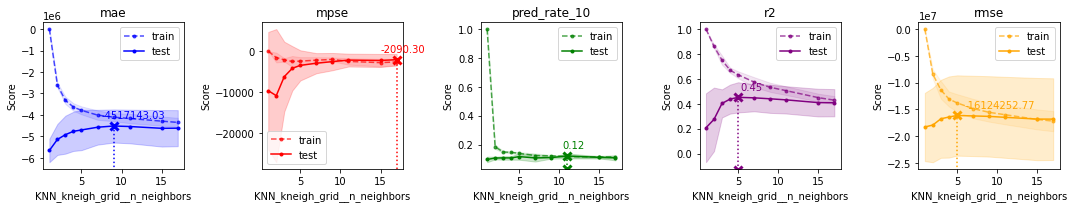

In [253]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

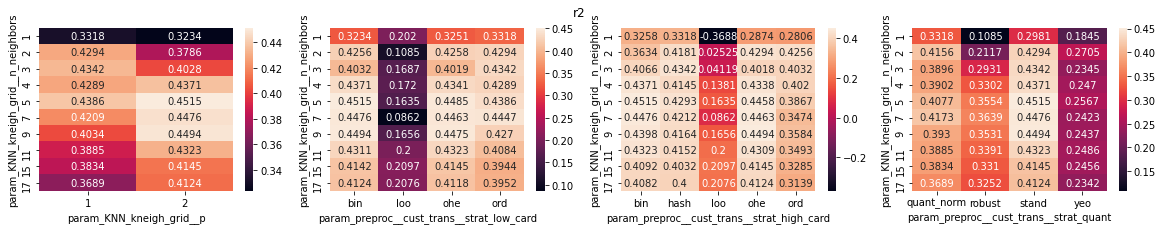

In [254]:
# Effect of encoding on performance

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__cust_trans__strat_low_card'
param4 = 'preproc__cust_trans__strat_high_card'
param5 = 'preproc__cust_trans__strat_quant'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = 'r2', ax=ax)

The best minkowski metric for the distance is Euclidian distance.

- Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


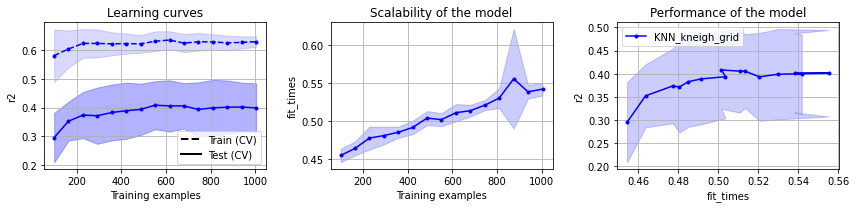

In [255]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

In [256]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'ZscoreOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'zo_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'yeo'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [257]:
# Best parameters
dict_models[name_reg].best_params_

{'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ord',
 'preproc__cust_trans__strat_quant': 'stand',
 'zo_KNN_kneigh_grid__n_neighbors': 3,
 'zo_KNN_kneigh_grid__p': 1}

The best encoding strategy (among 'ohe', 'bin', 'ord', 'loo') for KNN seems to be:
- low cardinality : binary
- high cardinality : binary

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

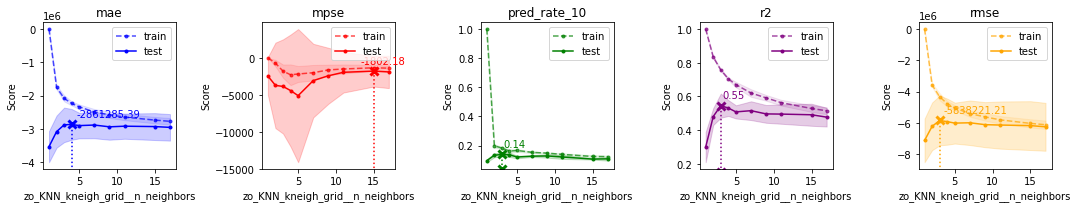

In [258]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

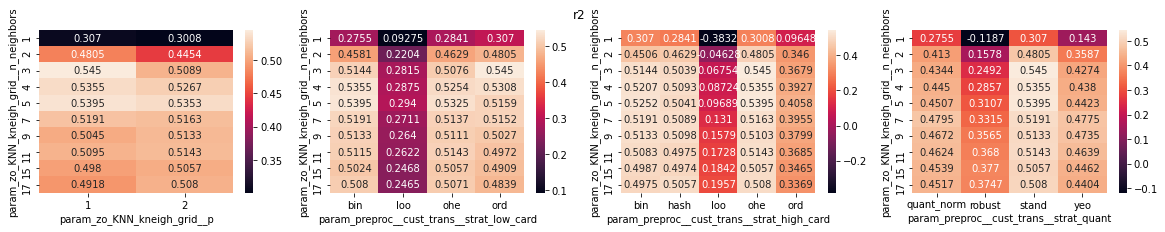

In [259]:
# Effect of encoding on performance

# name_reg = 'KNN_kneigh_grid'

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__cust_trans__strat_low_card'
param4 = 'preproc__cust_trans__strat_high_card'
param5 = 'preproc__cust_trans__strat_quant'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = 'r2', ax=ax)

The best minkowski metric for the distance is Euclidian distance.

- Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


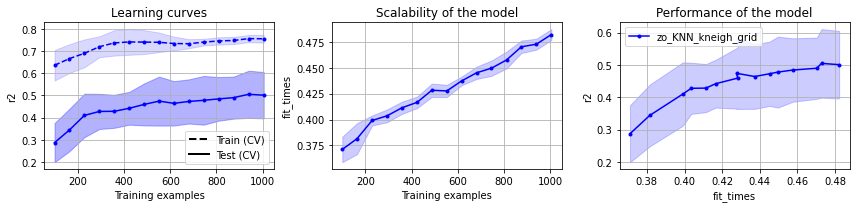

In [260]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

The learning curve shows that the model still continues to learn after 1300 observation. The lack of data may be the cause of the relatively bad results.

In [261]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'lo_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'yeo'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [262]:
# Best parameters
dict_models[name_reg].best_params_

{'lo_KNN_kneigh_grid__n_neighbors': 5,
 'lo_KNN_kneigh_grid__p': 2,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'bin',
 'preproc__cust_trans__strat_low_card': 'bin',
 'preproc__cust_trans__strat_quant': 'stand'}

The best encoding strategy (among 'ohe', 'bin', 'ord', 'loo') for KNN seems to be:
- low cardinality : binary
- high cardinality : binary

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

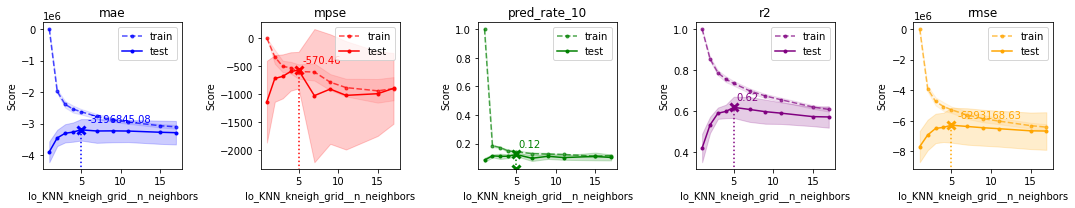

In [263]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

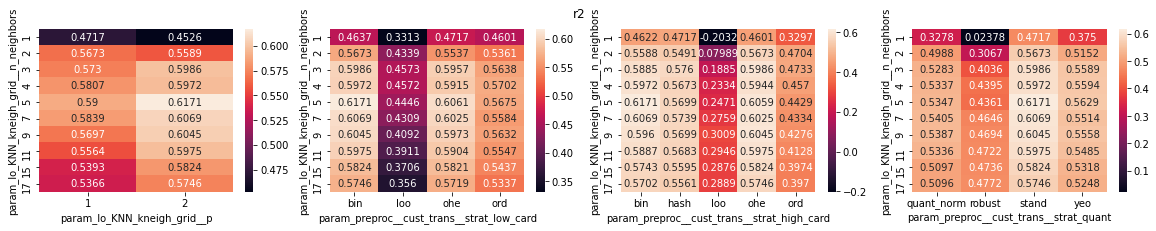

In [264]:
# Effect of encoding on performance

# name_reg = 'KNN_kneigh_grid'

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__cust_trans__strat_low_card'
param4 = 'preproc__cust_trans__strat_high_card'
param5 = 'preproc__cust_trans__strat_quant'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = 'r2', ax=ax)

The best minkowski metric for the distance is Euclidian distance.

- Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


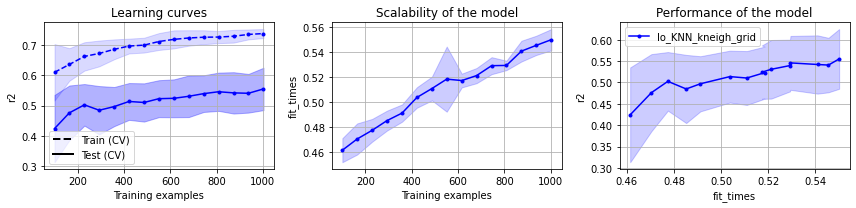

In [265]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

The learning curve shows that the model still continues to learn after 1300 observation. The lack of data may be the cause of the relatively bad results.

In [266]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'IsolFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'io_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'yeo'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [267]:
# Best parameters
dict_models[name_reg].best_params_

{'io_KNN_kneigh_grid__n_neighbors': 4,
 'io_KNN_kneigh_grid__p': 1,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'bin',
 'preproc__cust_trans__strat_quant': 'stand'}

The best encoding strategy (among 'ohe', 'bin', 'ord', 'loo') for KNN seems to be:
- low cardinality : binary
- high cardinality : binary

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

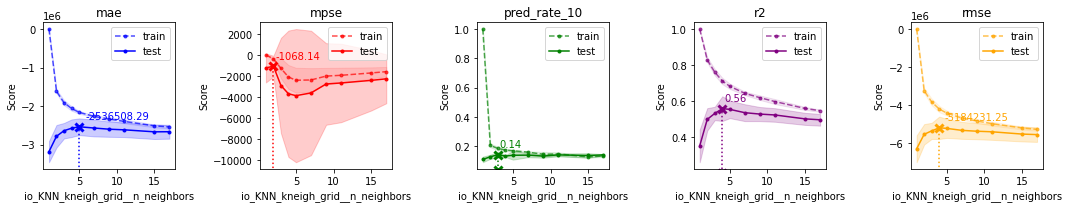

In [268]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

- Showing influence of both hyperparameters on one the refit_score.

_NB: The score displayed for each cell is the one for the best other parameters_

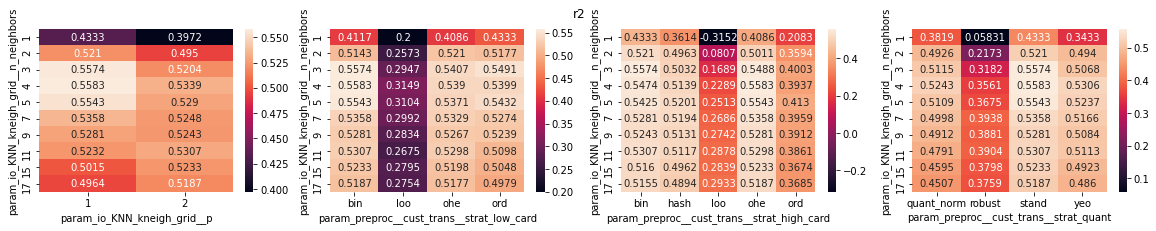

In [269]:
# Effect of encoding on performance

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__cust_trans__strat_low_card'
param4 = 'preproc__cust_trans__strat_high_card'
param5 = 'preproc__cust_trans__strat_quant'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = 'r2', ax=ax)

The best minkowski metric for the distance is Euclidian distance.

- Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


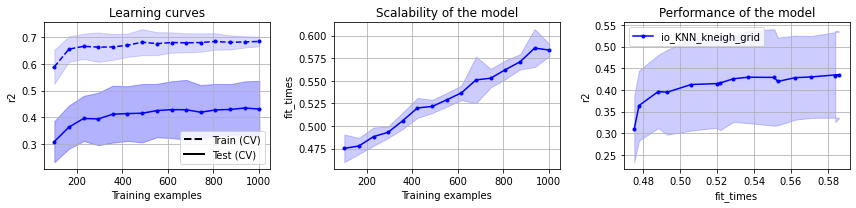

In [270]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

The learning curve shows that the model still continues to learn after 1300 observation. The lack of data may be the cause of the relatively bad results.

CONCLUSIONS :
- best k is between 3 and 5
- best encoding techniques are 'bin' and 'ohe' for high cardinality
- or 'bin', 'ohe' and 'ord' for low cardinality
- best transformation for numerical values is always 'stand'
- best p parameter is mostly 1

We've found the best KNN model for three different outlier filtering algorithms applied to the same training set. We hope that this outlier filtering will increase the ability of the model to generalize on a test set never seen before.

Let's check if it is the case.

In [271]:
# Cross-validation scores on training set
names = df_res.columns[df_res.columns.str.contains('KNN')]
lines = df_res.index[df_res.index.str.startswith('mean_test')]
df_res.loc[lines, names]

,KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid
mean_test_r2,0.45,0.55,0.62,0.56
mean_test_mae,-4701608.07,-2875868.69,-3196845.08,-2575471.58
mean_test_rmse,-16124252.77,-5838221.21,-6293168.63,-5184231.25
mean_test_mpse,-3484.38,-3873.03,-570.46,-3688.07
mean_test_pred_rate_10,0.12,0.14,0.12,0.13


In [272]:
# # Scores on test set
# df_test = pd.DataFrame()
# names = ['KNN_kneigh_grid']+[pre+'o_KNN_kneigh_grid' for pre in ['z', 'l', 'i']]
# for n in names:
#     model = dict_models[n].best_estimator_
#     df_ = compute_test_scores(n, model, X_te, y_te, scoring_test=dict_scv_params['scv_scores'])
#     df_test = pd.concat([df_test, df_], axis=1)
# df_test

#### Is log transformation helping ?

In [273]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'ZscoreOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'zo_log_KNN_kneigh_grid'

# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [2,3,4,5,7], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [274]:
# Best parameters
dict_models[name_reg].best_params_

{'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'bin',
 'preproc__cust_trans__strat_quant': 'stand',
 'zo_log_KNN_kneigh_grid__n_neighbors': 3,
 'zo_log_KNN_kneigh_grid__p': 2}

- Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

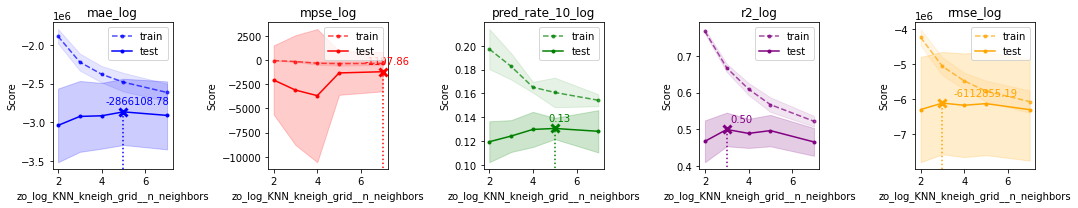

In [275]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

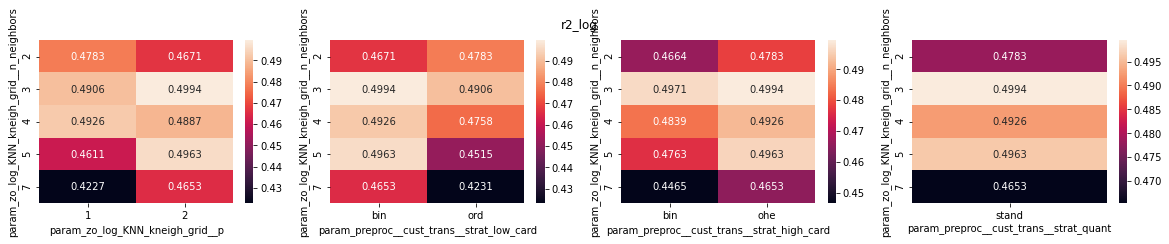

In [276]:
# Effect of encoding on performance

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__cust_trans__strat_low_card'
param4 = 'preproc__cust_trans__strat_high_card'
param5 = 'preproc__cust_trans__strat_quant'
score = 'r2_log'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=ax)

The best parameter for pred_rate_10 is k=6
The log transformation of the target seems to considerabily decrease the best values of the mpse, but the best r2 score is worse.

Without surprise, the log transformation does not lead to better scores of the KNN.

#### Feature selection using SelectKBest

The KNN algorithms does not assign weight to features (either 'coef_' nor 'feauture_importance_', we will then use SelectKbest (checking Pearson Correlation (f_regression) or mutual information (mutual_info_regression) to find the best parameters.

- Checking for feature importance

Let's see at first the permutation importance of the variables in the model (without and with log transformation).

-----Permutation importance - taking existing model
-----...model dumped


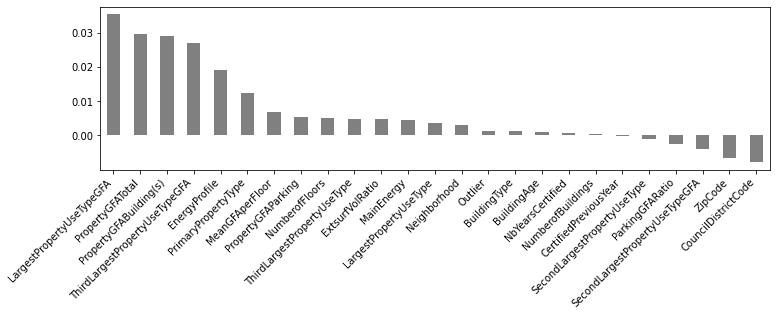

In [277]:
# Permutation importances

name_reg = 'zo_KNN_kneigh_grid'
dict_scv_params, _, _, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit='r2')
model = dict_models[name_reg].best_estimator_

# del dict_pimp[name_reg] # to overwrite existing permutation importances
dict_pimp = plot_perm_importance(model, name_reg, dict_scv_params['X'],
                        dict_scv_params['y'], scoring='r2',
                        dict_perm_imp = dict_pimp,
                        file_name=perm_imp_file_name)

The most important features are GFAreas, EnergyProfile and PrimaryPropertyType.

Let's now see if a feature selection using SelectKBest gives better score. As R2 depends on the number of features, we will use rmse as the refit_score given to GridSearchCV.

In [278]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

target = 'SEU'
outlier_filt_strat = 'ZscoreOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'zo_KNN_selkbest_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe',], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'feat_sel__k_best__k': np.arange(1,26,2), # np.arange(1,26,2)
            'feat_sel__k_best__score_func': [mutual_info_regression, f_regression], #,mutual_info_regression, f_regression
            name_reg+'__n_neighbors': [3,5,7,9,11,13], # 3,4,5,7,9,11
            # name_reg+'__weights': ['uniform', 'distance'], # 'uniform', 'distance'
            name_reg+'__p': [1]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score = 'rmse'

feat_sel_pipe = Pipeline([('k_best', SelectKBest())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('feat_sel', feat_sel_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [279]:
# Best parameters
dict_models[name_reg].best_params_

{'feat_sel__k_best__k': 7,
 'feat_sel__k_best__score_func': <function sklearn.feature_selection._univariate_selection.f_regression>,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ord',
 'preproc__cust_trans__strat_quant': 'stand',
 'zo_KNN_selkbest_grid__n_neighbors': 9,
 'zo_KNN_selkbest_grid__p': 1}

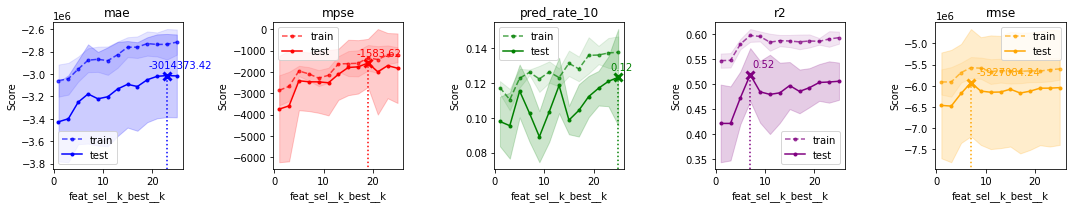

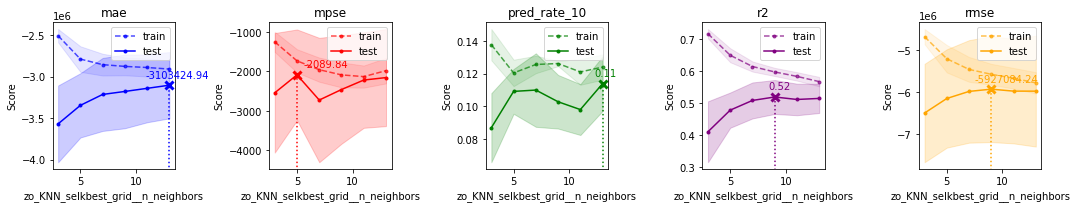

In [280]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 

plot_scv_multi_scores(name_reg, scv, param = 'feat_sel__k_best__k',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

In [281]:
# Effect of encoding on performance
### A DEBUGGER 

# param1 = name_reg+'__'+'n_neighbors'
# param2 = 'feat_sel__k_best__k'
# param3 = 'feat_sel__k_best__score_func'
# score = 'rmse'

# fig = plt.figure(figsize=(20,3))
# ax = fig.add_subplot(1,2,1)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
#                        score = score, ax=ax)
# ax = fig.add_subplot(1,2,2)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
#                        score = score, ax=ax)

In [282]:
speak('youpi cé fini')

- Dimensionality reduction using a PCA

The PCA in the P4_Cleaning notebook gave 4 principal components that contained almost 80% of the variance of the dataset. PCA may be able to give a model with few feature.

In [283]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

target = 'SEU'
outlier_filt_strat = 'ZscoreOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'zo_KNN_pca_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'dim_red__pca__n_components': np.arange(2,25,2),
            name_reg+'__n_neighbors': [3,5,7,9,11,13], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score = 'rmse'

dim_red_pipe = Pipeline([('pca', PCA())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('dim_red', dim_red_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [284]:
speak("youpi cé fini")

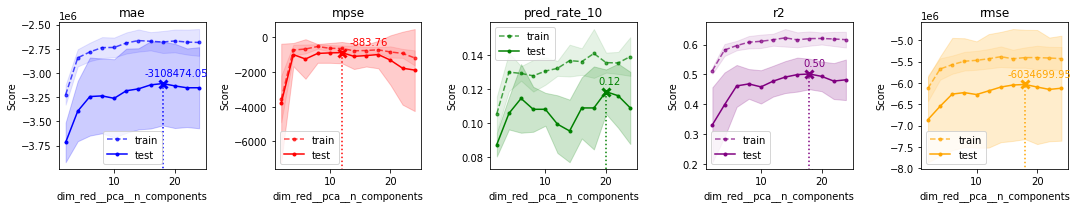

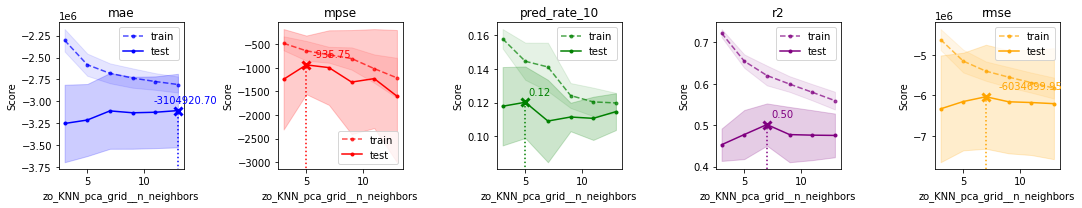

In [285]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = 'dim_red__pca__n_components',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

In [286]:
KNN_cols = df_res.columns[df_res.columns.str.contains('KNN')]
df_res[KNN_cols]

,KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid,zo_log_KNN_kneigh_grid,zo_KNN_selkbest_grid,zo_KNN_pca_grid
best_params,"{'KNN_kneigh_grid__n_neighbors': 5, 'KNN_kneigh_grid__p': 2, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'bin', 'preproc__cust_trans__strat_low_card': 'bin', 'preproc__cust_trans__strat_quant': 'stand'}","{'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ord', 'preproc__cust_trans__strat_quant': 'stand', 'zo_KNN_kneigh_grid__n_neighbors': 3, 'zo_KNN_kneigh_grid__p': 1}","{'lo_KNN_kneigh_grid__n_neighbors': 5, 'lo_KNN_kneigh_grid__p': 2, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'bin', 'preproc__cust_trans__strat_low_card': 'bin', 'preproc__cust_trans__strat_quant': 'stand'}","{'io_KNN_kneigh_grid__n_neighbors': 4, 'io_KNN_kneigh_grid__p': 1, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'bin', 'preproc__cust_trans__strat_quant': 'stand'}","{'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'bin', 'preproc__cust_trans__strat_quant': 'stand', 'zo_log_KNN_kneigh_grid__n_neighbors': 3, 'zo_log_KNN_kneigh_grid__p': 2}","{'feat_sel__k_best__k': 7, 'feat_sel__k_best__score_func': <function f_regression at 0x7eff175c5488>, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ord', 'preproc__cust_trans__strat_quant': 'stand', 'zo_KNN_selkbest_grid__n_neighbors': 9, 'zo_KNN_selkbest_grid__p': 1}","{'dim_red__pca__n_components': 18, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ord', 'preproc__cust_trans__strat_quant': 'stand', 'zo_KNN_pca_grid__n_neighbors': 7, 'zo_KNN_pca_grid__p': 1}"
mean_train_r2,0.63,0.76,0.73,0.71,NaN,0.60,0.62
std_train_r2,0.03,0.01,0.01,0.02,NaN,0.01,0.02
mean_train_mae,-3787586.24,-2078844.17,-2620549.15,-2061662.23,NaN,-2877090.90,-2679714.76
std_train_mae,185491.33,91997.15,87641.75,59957.69,NaN,107038.94,113421.37
mean_train_rmse,-13766224.50,-4325074.30,-5281880.06,-4198519.44,NaN,-5571480.31,-5404532.93
std_train_rmse,1628272.67,231050.41,211875.08,166884.65,NaN,249916.72,237577.81
mean_train_mpse,-2438.30,-1803.24,-595.58,-2096.88,NaN,-2090.85,-721.40
std_train_mpse,960.42,892.90,129.11,1137.33,NaN,316.30,168.66
mean_train_pred_rate_10,0.14,0.18,0.14,0.17,NaN,0.13,0.14


In [287]:
# ### A FIGNOLER
# p = np.arange(0, 7, 1)
# w = 0.4
# fig, axs = plt.subplots(1,2, sharey=True)
# score_train = ['mean_train_rmse', 'mean_train_rmse_log']
# score_test= ['mean_test_rmse', 'mean_test_rmse_log']

# # agg by max to deal with NaN values due to log scoring
# scores_ser_tr = df_res.loc[score_train].max() 
# scores_ser_te = df_res.loc[score_test].max()

# for ax, t in zip(axs, ['un', 'deux']):
#     ax.bar(p, scores_ser_tr, width=w, color= 'b',alpha = 0.5, label='train')
#     ax.bar(p+w, scores_ser_te, width=w, color= 'b', label='test')
#     ax.set_ylabel('RMSE')
#     ax.set_xticks(p+w/2);
#     ax.set_xticklabels(d.index)
#     plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
#     ax.legend()
# fig.set_size_inches(10,3)
# plt.show()

WE KEEP : 
'lo_KNN_kneigh_grid' as it minimizes the mpse, maximizes the r2 with tolerable overfitting level. 

In [288]:
speak("KNN done")

### 2.2 Linear Regressions

#### Finding best encoding

In [289]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import scipy.stats as st

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = Ridge()
name_reg = 'lo_Ridge_alpha_enc_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': np.logspace(-5,5,20) } #   st.loguniform(1e-7, 1e7)
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


-----Model already exists - taking existing model
-----...model dumped


In [290]:
# Best parameters
dict_models[name_reg].best_params_

{'lo_Ridge_alpha_enc_grid__alpha': 20.6913808111479,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'loo',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

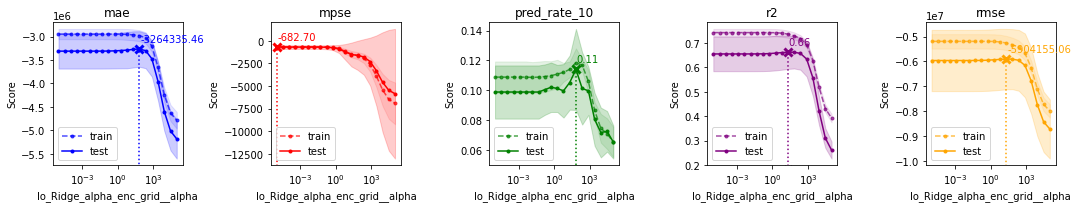

In [291]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__alpha', x_log=True,
                      loc=3, title = None, figsize = (15, 3))

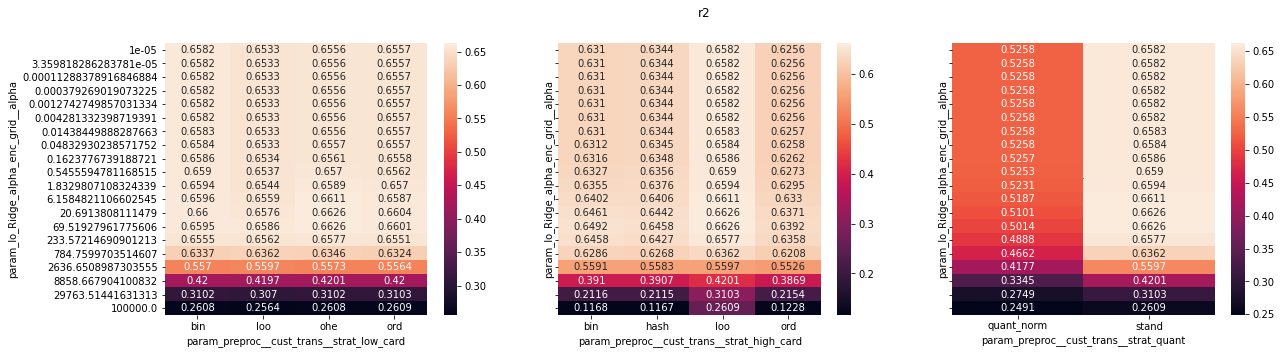

In [292]:
# Effect of encoding on performance
param1 = name_reg+'__'+'alpha'
param2 = 'preproc__cust_trans__strat_low_card'
param3 = 'preproc__cust_trans__strat_high_card'
param4 = 'preproc__cust_trans__strat_quant'

fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=axs[2])

The encoding strategy of categorical values give very similar result for low cardinality values. To make the interpretation easier, we'll choose 'ordinal' encoding.

However, a LeaveOneOut strategy leads to better results for high cardinality.

The StansardScaler method gives better results that the QuantileTransformer with normal distribution.

50 50


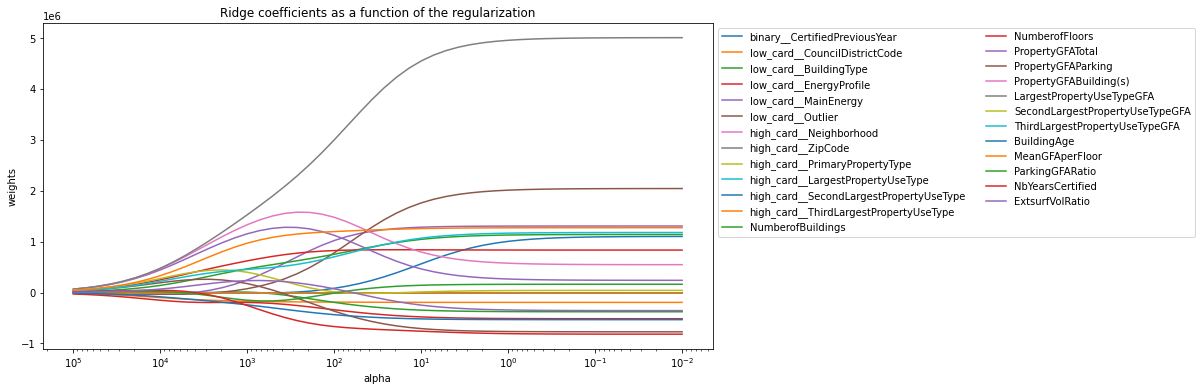

In [293]:
# Regularization path, taking all the best parameters other than alpha 
### FAIRE QUELQUE CHOSE POUR MIEUX DISTINGUER LES NOMS DES FEATURES SUR LES LIGNES (PYPLOT ?)
d_preproc = {'strat_binary': 'ord',
            'strat_low_card': 'ord', 
            'strat_high_card': 'loo', 
            'strat_quant': 'stand'}
plot_compute_reg_path(d_preproc, X_tr, y_tr, 'ridge', alphas=np.logspace(-2,5,50))

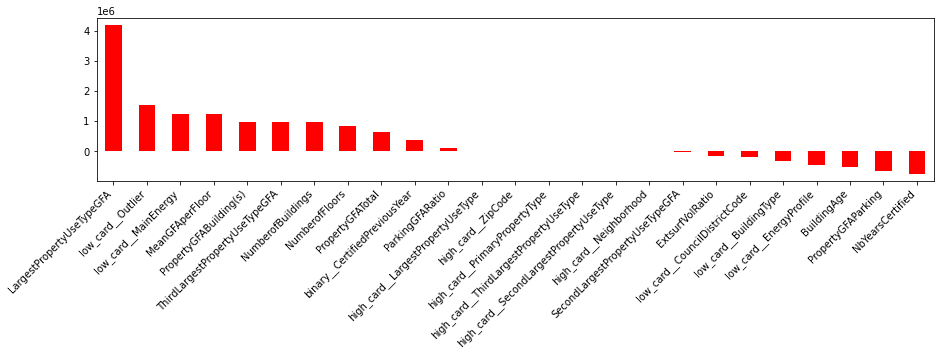

In [294]:
# Feature importance (coef_)
#### A CHANGER, mettre le meilleur alpha...
d_preproc = {'strat_binary': 'ord',
            'strat_low_card': 'ord', 
            'strat_high_card': 'loo', 
            'strat_quant': 'stand'}
preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
best_ridge = Pipeline([('preproc', preproc_pipe),
                  ('ridge', Ridge(alpha=21, fit_intercept=False))])
best_ridge.fit(X_tr, y_tr)

plot_model_feat_imp('ridge', best_ridge)

-----Permutation importance - taking existing model
-----...model dumped


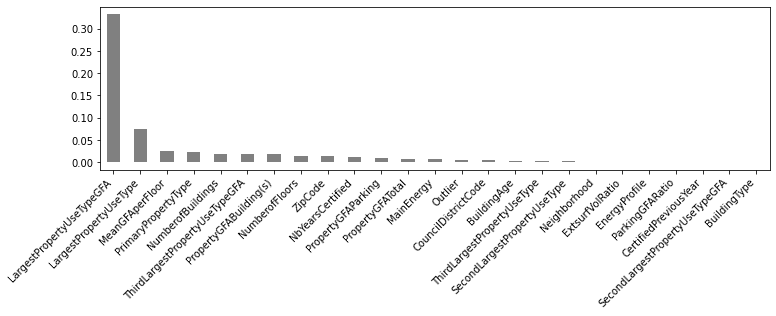

In [295]:
# Permutation importances
# name_reg = 'Ridge_alpha_enc_grid'
# dict_scv_params, _, _, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit='r2')
# model = dict_models[name_reg].best_estimator_

# to overwrite existing permutation importances
# if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
dict_pimp = plot_perm_importance(best_ridge, 'ridge', X_tr, y_tr, scoring=r2,
                                 dict_perm_imp = dict_pimp,
                                 file_name=perm_imp_file_name)

#### With log transformation (best alpha and best encoding)

In [296]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import scipy.stats as st

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

reg = Ridge()

name_reg = 'lo_log_Ridge_alpha_enc_grid' # best r2 0.49, best pred_rate_10 0.13 mpse -148
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'robust', 'norm', 'quant_norm', 'none'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             name_reg+'__alpha': np.logspace(-4,4,20) } #   st.loguniform(1e-7, 1e7)

# name_reg = 'lo_log_Ridge_alpha_enc_grid2' # best r2 0.19, best pred_rate_10 0.12 mpse -135
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             name_reg+'__alpha': np.logspace(-2,10,20) } #   st.loguniform(1e-7, 1e7)

name_reg = 'lo_log_Ridge_alpha_enc_grid3' # best r2 0.57, best pred_rate_10 0.15 mpse -706
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ord','loo', 'ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord', 'loo', 'ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_norm', 'quant_uni', 'maxabs', 'boxcox'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'boxcox'
            name_reg+'__alpha': np.logspace(-7,7,10) } #   st.loguniform(1e-7, 1e7)

search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


-----Model already exists - taking existing model
-----...model dumped


In [297]:
# Best parameters
dict_models[name_reg].best_params_

{'lo_log_Ridge_alpha_enc_grid3__alpha': 0.004641588833612782,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'loo',
 'preproc__cust_trans__strat_low_card': 'bin',
 'preproc__cust_trans__strat_quant': 'quant_uni'}

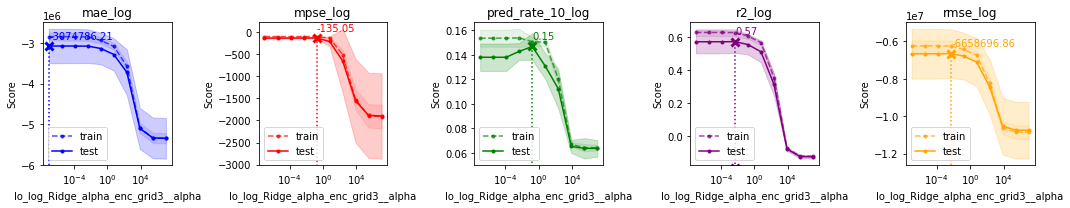

In [298]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__alpha', x_log=True,
                      loc=3, title = None, figsize = (15, 3))

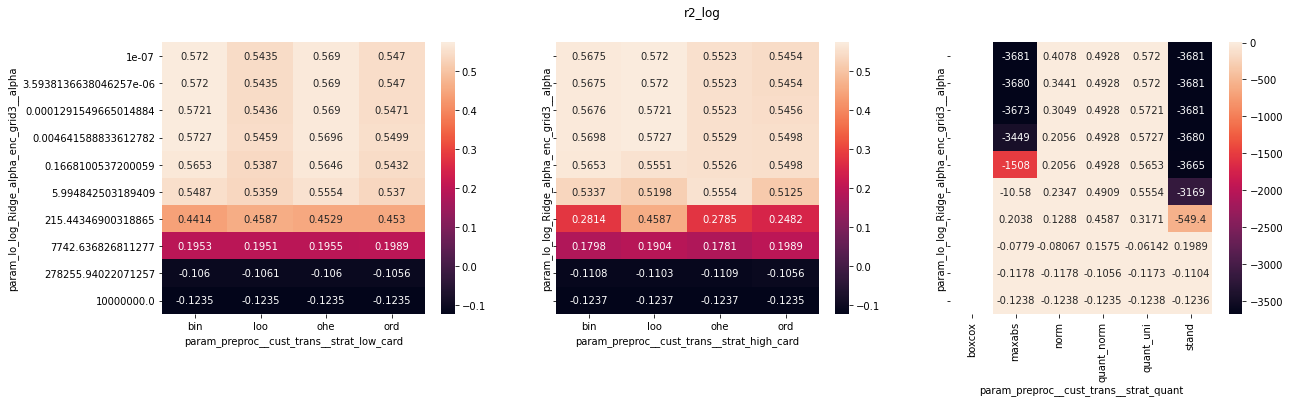

In [299]:
# Effect of encoding on performance
param1 = name_reg+'__'+'alpha'
param2 = 'preproc__cust_trans__strat_low_card'
param3 = 'preproc__cust_trans__strat_high_card'
param4 = 'preproc__cust_trans__strat_quant'
score = 'r2_log'

fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])

The encoding strategy of categorical values give very similar result for low cardinality values. To make the interpretation easier, we'll choose 'ordinal' encoding.

However, a LeaveOneOut strategy leads to better results for high cardinality.

The StansardScaler method gives better results that the QuantileTransformer with normal distribution.

In [300]:
# Regularization path, taking all the best parameters other than alpha 
### FAIRE QUELQUE CHOSE POUR MIEUX DISTINGUER LES NOMS DES FEATURES SUR LES LIGNES (PYPLOT ?)
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# plot_compute_reg_path(d_preproc, X_tr, y_tr, 'ridge', alphas=np.logspace(-2,5,50))

In [301]:
# Feature importance (coef_)
### COEFF ALPHA ET ENCODAGE A VERIFIER !!!!!!!!!!!!!!
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# best_ridge = Pipeline([('preproc', preproc_pipe),
#                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# best_ridge.fit(X_tr, y_tr)

# plot_model_feat_imp('ridge', best_ridge)

In [302]:
# Permutation importances

# dict_pimp = plot_perm_importance(best_ridge, 'ridge', X_tr, y_tr, scoring=r2,
#                                  dict_perm_imp = dict_pimp,
#                                  file_name=perm_imp_file_name)

Après choix du meilleur encodage et de log ou pas
QUAND MEME ESSAYER DE FITTER D'AUTRES PARAMETRES :
FIT INTERCEPT, sgd, ridge, lasso, elasticnet

In [303]:
speak("linear regressions done")

### 2.3 Random Forest Regressor

In [304]:
# n_estimators=100 # maximise toujours les résultats
# max_features='auto' # nb maximum de variables dans un arbre
# max_depth=None # seuil du nombre maximum de noeuds d'un arbre de haut en bas (pruning)
# min_samples_split=2 # min nb of observations to allow split
# min_samples_leaf=1 # min number of observations ine a leaf
# bootstrap=True # methode for sampling the data

# criterion='mse',
# min_weight_fraction_leaf=0.0
# max_samples=None
# max_leaf_nodes=None # nb maximum de feuilles en tout par arbre
# min_impurity_decrease=0.0,
# min_impurity_split=None

# oob_score=False
# warm_start=False
# ccp_alpha=0.0

#### Random Forest hyperparameters

Let's find the best random forest hyperparameters at first

In [305]:
from sklearn.ensemble import RandomForestRegressor

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

reg = RandomForestRegressor()

# name_reg = 'lo_RF_RFparams_rand' # r2: 0.6983
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#              name_reg+'__bootstrap': [True, False],
#              name_reg+'__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#              name_reg+'__max_features': ['auto', 'sqrt'], #
#              name_reg+'__min_samples_leaf': [1, 2, 4], #
#              name_reg+'__min_samples_split': [2, 5, 10],
#              name_reg+'__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]} #

# name_reg = 'lo_RF_RFparams_grid'
# # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#              name_reg+'__bootstrap': [True], # pas capital
#              name_reg+'__max_depth': [10, 30, 100, 1000],
#              name_reg+'__max_features': ['sqrt'], # pas capital
#              name_reg+'__min_samples_leaf': [1, 2, 4], #
#              name_reg+'__min_samples_split': [3, 6, 10],
#              name_reg+'__n_estimators': [100, 500, 1000, 2000]} #

name_reg = 'lo_RF_RFparams_grid2'
# del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
             name_reg+'__bootstrap': [False], # pas capital
             name_reg+'__max_depth': [10,15, 20, 30, 50],
             name_reg+'__max_features': ['sqrt'], # pas capital
             name_reg+'__min_samples_leaf': [1], #
             name_reg+'__min_samples_split': [2],
             name_reg+'__n_estimators': [10, 50, 100,150, 200,250, 300]} #
            
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [306]:
# Best parameters
dict_models[name_reg].best_params_

{'lo_RF_RFparams_grid2__bootstrap': False,
 'lo_RF_RFparams_grid2__max_depth': 20,
 'lo_RF_RFparams_grid2__max_features': 'sqrt',
 'lo_RF_RFparams_grid2__min_samples_leaf': 1,
 'lo_RF_RFparams_grid2__min_samples_split': 2,
 'lo_RF_RFparams_grid2__n_estimators': 150,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ord',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

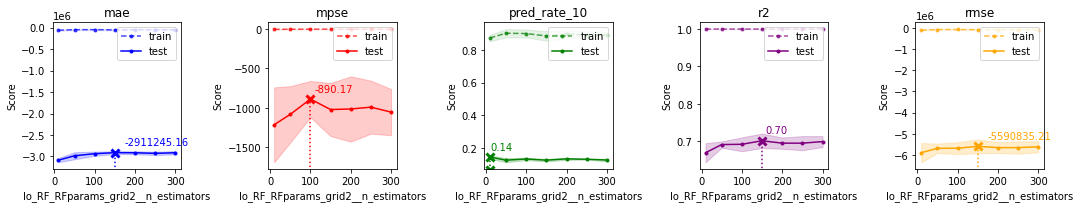

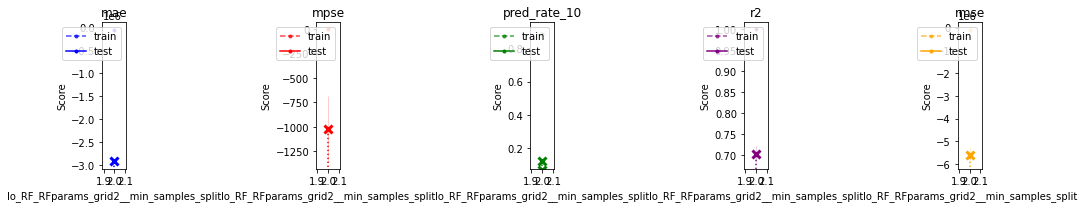

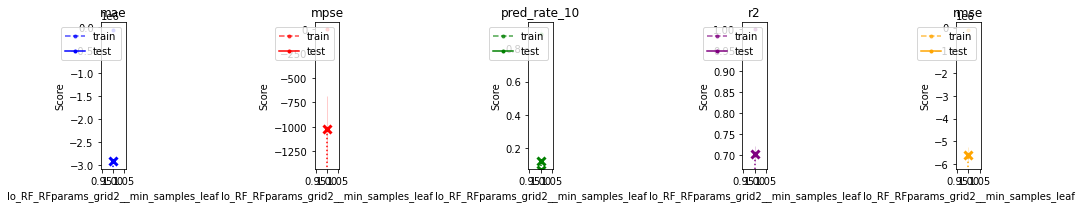

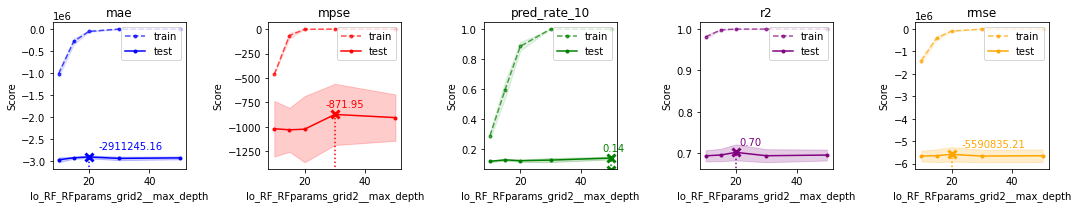

In [307]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_estimators', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_split', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_leaf', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__max_depth', x_log=False,
                      loc=1, title = None, figsize = (15, 3))

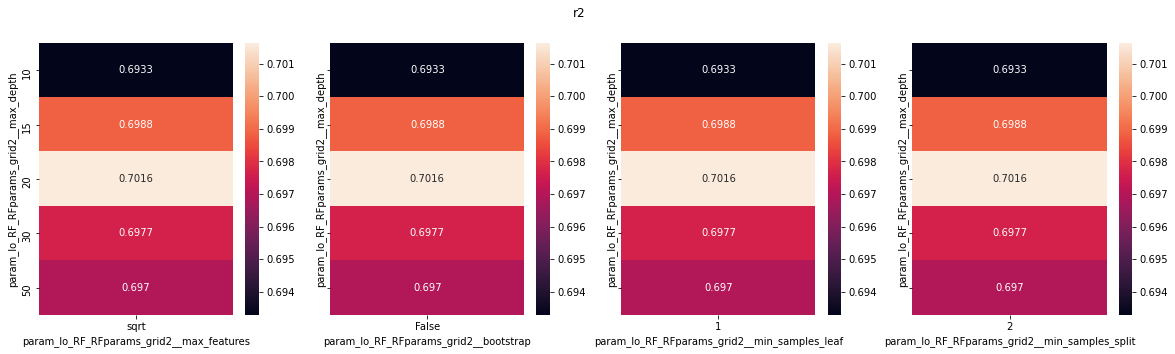

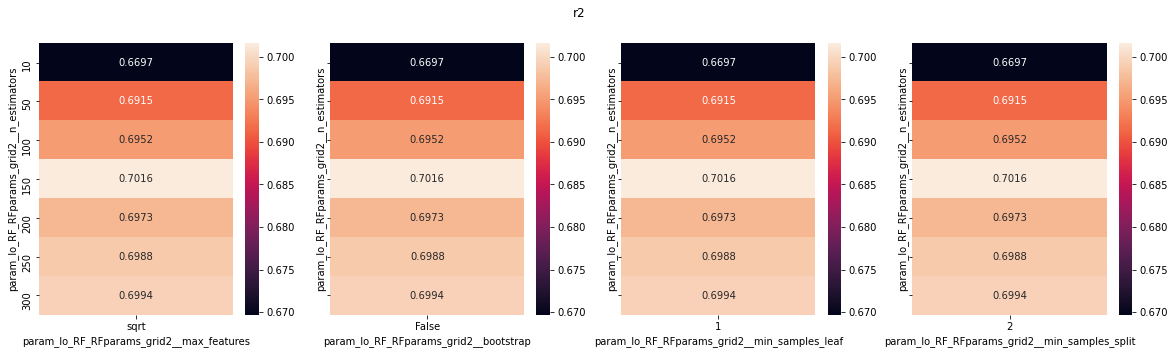

In [308]:
# Effect of hyperparameters on performance

param1 = name_reg+'__max_depth'
param1bis = name_reg+'__n_estimators'
param2 = name_reg+'__max_features'
param3 = name_reg+'__bootstrap'
param4 = name_reg+'__min_samples_leaf'
param5 = name_reg+'__min_samples_split'

score = 'r2'

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=axs[3])

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param5],
                       score = score, ax=axs[3])

----- Learning curve not existing - computing...
-----...learning curve dumped


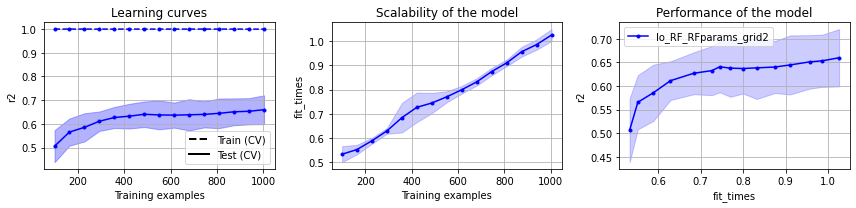

In [309]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

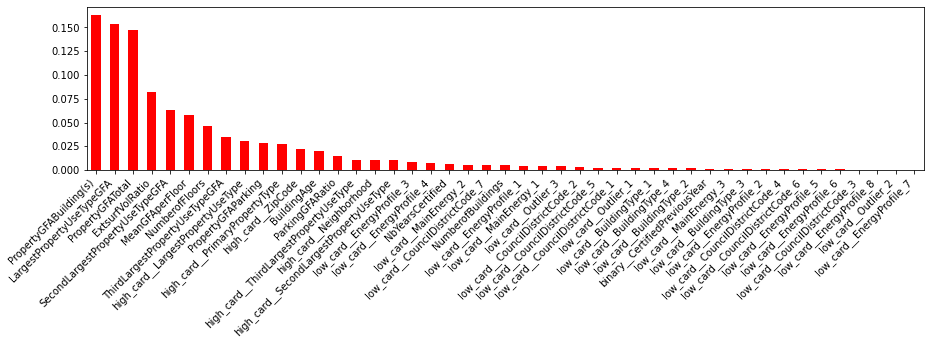

In [310]:
# Feature importance (coef_ or feature_importances_)

# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# best_ridge = Pipeline([('preproc', preproc_pipe),
#                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# best_ridge.fit(X_tr, y_tr)

plot_model_feat_imp(name_reg, dict_models[name_reg].best_estimator_)

-----Permutation importance not existing - computing...
-----...model dumped


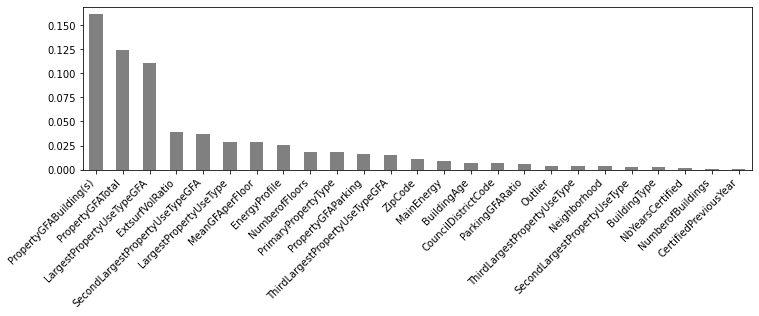

In [311]:
# Permutation importances

# to overwrite existing permutation importances
# if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
dict_pimp = plot_perm_importance(dict_models[name_reg].best_estimator_, name_reg,
                                 X_tr, y_tr, scoring=r2,
                                 dict_perm_imp = dict_pimp,
                                 file_name = perm_imp_file_name)

#### Encoding and numerical transformation optimization

Is encoding able to improve the scores ?

In [312]:
from sklearn.ensemble import RandomForestRegressor

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

reg = RandomForestRegressor()

# name_reg = 'lo_RF_enc_grid'
# # del dict_models[name_reg] # to overwrite an existing model # r2: 0.717
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe','bin', 'ord','loo'], # 'ohe'
#             'preproc__cust_trans__strat_high_card': ['bin', 'ord','loo'], # 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'quant_uni', 'quant_norm'], # 'quant_uni'
#              name_reg+'__bootstrap': [False], # pas capital
#              name_reg+'__max_depth': [20],
#              name_reg+'__max_features': ['sqrt'], # pas capital
#              name_reg+'__min_samples_leaf': [1], #
#              name_reg+'__min_samples_split': [2],
#              name_reg+'__n_estimators': [100]} #

name_reg = 'lo_RF_enc_grid2'
# del dict_models[name_reg] # to overwrite an existing model # r2: 0.7164
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['quant_uni'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
             name_reg+'__bootstrap': [False, True], # pas capital
             name_reg+'__max_depth': [20,50],
             name_reg+'__max_features': ['sqrt', 'auto'], # pas capital
             name_reg+'__min_samples_leaf': [1,2,3], #
             name_reg+'__min_samples_split': [2,4],
             name_reg+'__n_estimators': [50,100,150,200]} #
            
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model already exists - taking existing model
-----...model dumped


In [313]:
# Best parameters
dict_models[name_reg].best_params_

{'lo_RF_enc_grid2__bootstrap': False,
 'lo_RF_enc_grid2__max_depth': 50,
 'lo_RF_enc_grid2__max_features': 'sqrt',
 'lo_RF_enc_grid2__min_samples_leaf': 1,
 'lo_RF_enc_grid2__min_samples_split': 4,
 'lo_RF_enc_grid2__n_estimators': 150,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'loo',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'quant_uni'}

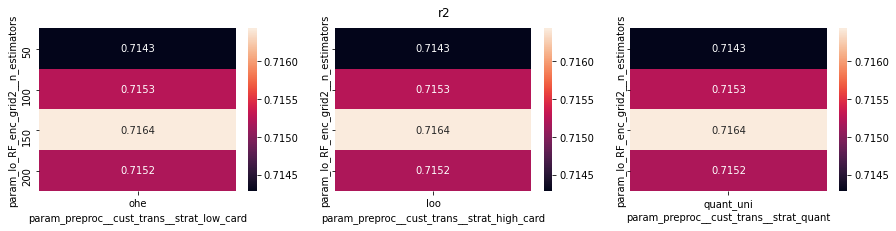

In [314]:
# Effect of encoding on performance

param1 = name_reg+'__n_estimators'
param2 = 'preproc__cust_trans__strat_low_card'
param3 = 'preproc__cust_trans__strat_high_card'
param4 = 'preproc__cust_trans__strat_quant'

score = 'r2'

fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
#                        score = score, ax=axs[3])

#### Feature Selection

Is a feature selection allowing for better result ?

In [329]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

reg = RandomForestRegressor()

name_reg = 'lo_RF_selfmodel_grid'
# del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['quant_uni'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm',
            # 'feat_sel__sfm__threshold': [-np.inf],
            # 'feat_sel__sfm__max_features': np.arange(5,25,2),
             name_reg+'__bootstrap': [False], # pas capital
             name_reg+'__max_depth': [50],
             name_reg+'__max_features': ['sqrt'], # pas capital
             name_reg+'__min_samples_leaf': [1], #
             name_reg+'__min_samples_split': [4],
             name_reg+'__n_estimators': [150]} #
            
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])

sfm_reg = Pipeline([('preproc', preproc_pipe),
	    	         ('sfm_rf', RandomForestRegressor())]) 
sfm_reg.fit(X_tr, y_tr)
feat_sel_pipe = Pipeline([('sfm', SelectFromModel(sfm_reg))])

pipe = Pipeline([('preproc', preproc_pipe),
	    	    #  ('feat_sel', feat_sel_pipe),
	             (name_reg, reg)])

dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


-----Model not existing - computing...
Grid
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


-----...model dumped


In [316]:
len(dict_models.keys())

16

In [ ]:
speak("youpi the random forest cé fini ")

In [ ]:
df_res.columns

## 3 Stacking final regressor model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_validate

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

n_best_KNN = 'lo_KNN_kneigh_grid'
n_best_linear = 'lo_Ridge_alpha_enc_grid'
n_best_bagging = 'lo_RF_enc_grid'
# n_best_boosting = ''

best_KNN = dict_models[n_best_KNN].best_estimator_
best_linear = dict_models[n_best_linear].best_estimator_
best_bagging = dict_models[n_best_bagging].best_estimator_
# best_boosting = dict_models[n_best_boosting].best_estimator_

estimators = [('knn', best_KNN),
              ('lin', best_linear),
              ('bag', best_bagging),
            #   ('boost', best_boosting)
              ]
stacked_reg = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(random_state=42))

dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

stacked_reg.fit(X_tr, y_tr);

In [321]:
from sklearn.model_selection import cross_validate

# evaluation of the stacked model on the training set with cross-validation
cross_validate(stacked_reg, X_tr, y_tr,
                scoring=dict_scv_params['scv_scores'], cv=skf, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , mae=-3150656.313, mpse=-3473.854, pred_rate_10=0.139, r2=0.706, rmse=-6494939.291, total=  15.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s


[CV]  , mae=-2763728.690, mpse=-272.673, pred_rate_10=0.155, r2=0.689, rmse=-5185175.831, total=  15.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.2s remaining:    0.0s


[CV]  , mae=-3307157.851, mpse=-1020.884, pred_rate_10=0.120, r2=0.645, rmse=-6449332.059, total=  15.2s
[CV]  ................................................................
[CV]  , mae=-2553416.171, mpse=-192.215, pred_rate_10=0.135, r2=0.634, rmse=-4751602.152, total=  15.2s
[CV]  ................................................................
[CV]  , mae=-3303840.014, mpse=-320.509, pred_rate_10=0.128, r2=0.543, rmse=-7274929.457, total=  15.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


{'fit_time': array([14.85944915, 14.71548247, 14.86474347, 14.91804814, 14.8344152 ]),
 'score_time': array([0.31053066, 0.30952525, 0.31009316, 0.30442381, 0.30547285]),
 'test_mae': array([-3150656.31270573, -2763728.69008085, -3307157.85119302,
        -2553416.17114004, -3303840.01361389]),
 'test_mpse': array([-3473.85351943,  -272.67342388, -1020.88434314,  -192.21518677,
         -320.50931342]),
 'test_pred_rate_10': array([0.13944223, 0.15537849, 0.11952191, 0.13545817, 0.128     ]),
 'test_r2': array([0.70554199, 0.6887265 , 0.64514121, 0.63395685, 0.5426506 ]),
 'test_rmse': array([-6494939.29147834, -5185175.83087207, -6449332.05875103,
        -4751602.15196442, -7274929.45708119])}

In [ ]:
# VERSION MULTILAYER

from sklearn.ensemble import StackingRegressor

final_layer = StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                                            ('gbrt', GradientBoostingRegressor(random_state=42))],
                                final_estimator=RidgeCV())

stacked_reg = StackingRegressor( estimators=[('ridge', RidgeCV()),
                                             ('lasso', LassoCV(random_state=42)),
                                             ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
                                final_estimator=final_layer

stacked_reg.fit(X_tr, y_tr)

# A CORRIGER

### 2.3 Support Vector Machine Regression

In [ ]:
from sklearn.svm import SVR
import scipy.stats as st

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers, # df_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

reg = SVR()
name_reg = 'lo_SVR_lin_e_c_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'boxcox', 'yeo'
            name_reg+'__kernel': ['linear'], # kernel  ('linear' 'rbf', 'poly')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef
            name_reg+'__epsilon': np.logspace(-4,0,3),# st.loguniform(1e-4,1e0),#  # accepted error
            name_reg+'__C':  np.logspace(-7,7,3)}

search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
speak('youpi the SVR cé fini')

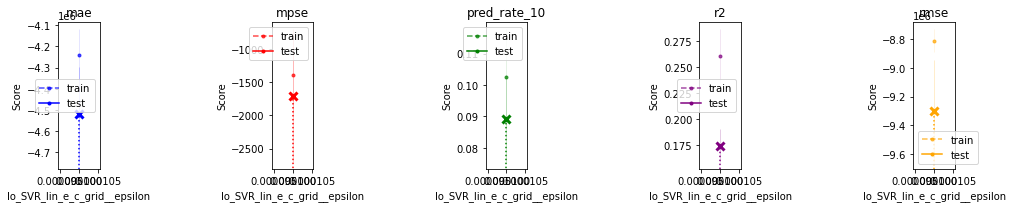

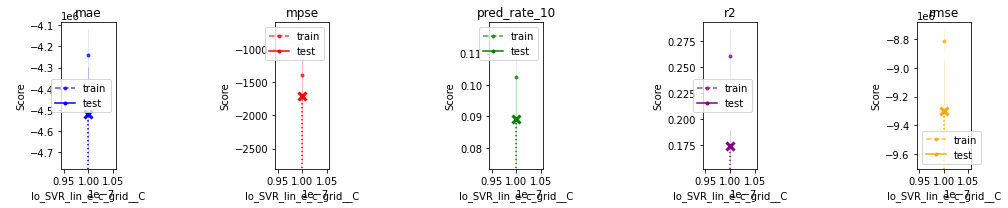

In [92]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__epsilon',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__C',
                      title = None, figsize = (15, 3))

In [ ]:
from sklearn.svm import SVR
import scipy.stats as st

reg = SVR()
name_reg = 'SVR_log_lin_e_c_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'none', 'boxcox'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__kernel': ['linear'], # kernel coef (radial basis function 'rbf', 'poly')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef (radial basis function 'rbf')
            name_reg+'__epsilon': np.logspace(-4,0,10), #st.loguniform(1e-4,1e0), # accepted error
            name_reg+'__C': np.logspace(-5,3,10)} #  np.logspace(-7,7,20)
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
from sklearn.svm import SVR
import scipy.stats as st

reg = SVR()
name_reg = 'SVR_log_poly_e_c_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'none', 'boxcox'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__kernel': ['linear'], # kernel coef (radial basis function 'rbf', 'poly')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef (radial basis function 'rbf')
            name_reg+'__epsilon': np.logspace(-4,0,10), #st.loguniform(1e-4,1e0), # accepted error
            name_reg+'__C': np.logspace(-5,3,10)} #  np.logspace(-7,7,20)
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
from sklearn.svm import SVR
import scipy.stats as st

reg = SVR()
name_reg = 'SVR_log_rbf_e_c_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'none', 'boxcox'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__kernel': ['linear'], # kernel coef (radial basis function 'rbf', 'poly')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef (radial basis function 'rbf')
            name_reg+'__epsilon': np.logspace(-4,0,10), #st.loguniform(1e-4,1e0), # accepted error
            name_reg+'__C': np.logspace(-5,3,10)} #  np.logspace(-7,7,20)
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
speak("linear regressions done")

### 2.3 Lasso

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso()
name_reg = 'Lasso_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7)} # np.logspace(-7,7,20)


### 2.4 ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
name_reg = 'ElasticNet_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7), # np.logspace(-7,7,20)
            name_reg+'__l1_ratio': st.uniform(0,1), # [0,0.15,0.3,0.45,0.6,0.75,1]
            name_reg+'__tol' : st.loguniform(1e-3, 1e0)} #np.logspace(-4,0,5)}


### 2.6 Support Vector Machine Regression

In [ ]:
from sklearn.svm import SVR
import scipy.stats as st

reg = SVR()
name_reg = 'SVR_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__kernel': ['rbf', 'linear', 'poly'], # kernel coef (radial basis function 'rbf')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef (radial basis function 'rbf')
            name_reg+'__epsilon': np.logspace(-3,0,5), # accepted error
            name_reg+'__C': np.logspace(-2,2,5)} # regularization coef
search_strat = 'grid'


### 2.5 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
name_reg = 'RandomForest_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'hash'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_estimators': [100,200,500],#,200,500,1000], # nb leaves
            name_reg+'__min_samples_leaf': [1,2,5,10], # mean nb leaves in a node
            name_reg+'__max_features': ['auto', 'sqrt']}#, 'sqrt']} # 'auto', 'sqrt' (nb features in a tree)


### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

loss='squared_loss', # OK default
penalty='l2', alpha=0.0001, l1_ratio=0.15,
fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0,
epsilon=0.1, random_state=None, learning_rate='invscaling', eta0=0.01,
power_t=0.25, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5,
warm_start=False, average=False

reg = SGDRegressor()
name_reg = 'lo_SGDreg_enc_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'hash'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'': [100,200,500],#,200,500,1000], # nb leaves
            name_reg+'': [1,2,5,10], # mean nb leaves in a node
            name_reg+'': ['auto', 'sqrt']}#, 'sqrt']} # 'auto', 'sqrt' (nb features in a tree)


### 2.7 XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

reg = XGBRegressor(objective ='reg:squarederror')# 'reg:lineaqr' deprecated
name_reg = 'XGBR_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'hash'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__learning_rate': np.logspace(-3,-1,3),
            name_reg+'__n_estimators': [1000,2000], # [100,200,500,1000,2000]
            name_reg+'__max_depth': [3,4],
            name_reg+'__subsample': [0.8,1],
            name_reg+'__colsample_bytree': [0.3,0.8,1], # [0.3,0.5,0.8,0.9,1]
            name_reg+'__gamma': [1]}


## 3 Comparison of the models
Plotting the main metrics of the optimized models obtained during SearchCV fitting (training/test folds)

In [ ]:
# dict_models_log_SEU = dict_models.copy()
# df_res_log_SEU = df_res.copy('deep')

In [ ]:
# dict_models_SEU = dict_models.copy()
# df_res_SEU = df_res.copy('deep')

In [ ]:
truc2 = df_res_log_SEU.loc[['mean_train_rev_log1p_neg_rmse', 'mean_test_rev_log1p_r2']]

In [ ]:
truc1 = df_res_SEU.loc[['mean_train_neg_root_mean_squared_error',  'mean_test_r2']]

In [ ]:
df_res_SEU.iloc[11]

In [ ]:
p = np.arange(0, 7, 1)
w = 0.4
fig, axs = plt.subplots(1,2, sharey=True)
for d, ax, t in zip([df_res_SEU, df_res_log_SEU], axs, ['SEU', 'log_SEU']):
    ax.bar(p, d.iloc[5], width=w, color= 'b',alpha = 0.5, label='train')
    ax.bar(p+w, d.iloc[11], width=w, color= 'b', label='test')
    ax.set_title(t)
    ax.set_ylabel('R²')
    ax.set_xticks(p+w/2);
    ax.set_xticklabels(d.columns)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
    ax.legend()
fig.set_size_inches(10,3)

Boucle pour learning curves

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3));

colors = sns.color_palette("dark", 10)
for name_reg, c in zip(dict_models.keys(), colors):
    # title = f"Learning Curves ({name_reg})"
    model = dict_models[name_reg].best_estimator_
    plot_learning_curve(model, X_tr, y_mod_tr, #ylim=(0.7, 1.01),
                        cv=cv, scoring = make_scorer(calc_pred_rate_10),#n_jobs=4,
                        train_sizes = np.linspace(0.1,1,2),
                        c=c, axes=None)
plt.show()

In [ ]:
plt.show()

In [ ]:
speak("youpi cé fini")

## 4. Performance of the final model

Plotting the predicted values against the true values in test set for different groups.

In [ ]:
name_reg='KNN_grid'
scv = dict_models[name_reg]

y1_pr = scv.predict(X_te)

col_groups = ['BuildingType', 'MainEnergy', 'Outlier']
fig, axs = plt.subplots(1,len(col_groups))
for c, ax in zip(col_groups, axs):
    sns.scatterplot(y1_te, y1_pr, hue=X_te[c], ax=ax)
    ax.set_xscale('log'), ax.set_yscale('log'),
    ax.set_xlabel('True value (y1_te)')
    ax.set_ylabel('Predicted value (y1_te_pr)')
    ax.legend( ncol=2, )#bbox_to_anchor=(0.6,-0.2),
fig.suptitle('SiteEnergyUseWN(kBtu)', fontsize=16, fontweight='bold')
fig.set_size_inches(5*len(col_groups),4)
fig.set_facecolor('w')
plt.show()